In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.io
import numpy as np

In [2]:
from matplotlib import rcParams
rcParams.update({
    "font.size": 14})

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [4]:
ssa_v = np.genfromtxt('./ssa/compare_data_output.csv')[1:, :]
b_val = ssa_v[:, 0]
h_val = ssa_v[:, 1]
u_val = ssa_v[:, 2]
xh_val = ssa_v[:, 3]
xu_val = ssa_v[:, 4]

In [5]:
xh_val[-1]

2.345833636298257

In [6]:
b_int = InterpolatedUnivariateSpline(xh_val, b_val)
b_x_int = b_int.derivative(n=1)
h_int = InterpolatedUnivariateSpline(xh_val, h_val)
h_x_int = h_int.derivative(n=1)

In [7]:
def b_x(x):
    if type(x) is torch.Tensor:
        x = x.detach()
    return torch.tensor(b_x_int(x)).float()

def h_x(x):
    if type(x) is torch.Tensor:
        x = x.detach()
    return torch.tensor(h_x_int(x)).float()

def b(x):
    if type(x) is torch.Tensor:
        x = x.detach()
    return torch.tensor(b_int(x)).float()

def h(x):
    if type(x) is torch.Tensor:
        x = x.detach()
    return torch.tensor(h_int(x)).float()

In [8]:
x_b0 = torch.tensor(0).reshape(-1, 1).float()
u_b0 = torch.tensor(0).reshape(-1, 1).float()
x_b1 = torch.tensor(xh_val[-1]).reshape(-1, 1).float()
x_b1.requires_grad=True
ux_b1 = torch.tensor(19.6523087).reshape(-1, 1).float()
x = torch.tensor(xu_val, requires_grad=True).reshape(-1, 1).float()

In [9]:
# dimensional parameters
eps = 0.002587853191
c_hat = 0.8501309976
m = 3
n = 3

In [19]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out,
        N_hid = 30, N_layers=3,
        loss_func=nn.MSELoss(),
        learning_rate = 0.01,
        optimizer = optim.Adam,
        act_func=nn.Tanh()
                ):
        
        super(Net, self).__init__()
        self.loss_func = loss_func

        # Initialise layers
        layers = [nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True), act_func]
        for _ in range(N_layers - 1):
            layers += [nn.Linear(in_features=N_hid,
                    out_features=N_hid,
                    bias=True), act_func]
        layers += [nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)]

        self.layers = nn.Sequential(*layers)
        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        # Save hyperparameters
        self.N_hid = N_hid
        self.N_layers = N_layers
        self.act_func = act_func
        self.learning_rate = learning_rate
        self.N_params = sum([p.numel() for p in self.parameters()])
        
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def PDE(self, x, h, h_x, b_x):
        # Evaluate network and derivatives
        u_hat = self.forward(x)
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape), create_graph=True)[0]
        
        # Calculate terms
        #prefactor = 4*eps
        #extensional_term1 = h_x(x) * torch.abs(u_x_hat)**(1/3-1) * u_x_hat
        #extensional_term2 = h(x)/3*torch.abs(u_x_hat)**(1/3-2)*u_xx_hat
        #extensional = prefactor * (extensional_term1 + extensional_term2)
        
        
        # Calculate extensional again
        prefactor = 4*eps*torch.abs(u_x_hat)**(1/3-1)
        extensional_term1 = h_x(x) * u_x_hat
        extensional_term2 = h(x)/3*u_xx_hat
        extensional = prefactor * (extensional_term1 + extensional_term2)

        
        basal = c_hat * torch.abs(u_hat)**(1/3-1)*u_hat
        driving = h(x) * (h_x(x) - b_x(x))
        
        pde = extensional - basal - driving
        return pde
    
    def loss_dirichlet(self, x_b0, u_b0):
        u_b0_hat = self.forward(x_b0)
        loss_b0 = self.loss_func(u_b0, u_b0_hat.reshape(u_b0.shape))
        return loss_b0
    
    def loss_neumann(self, x_b1, ux_b1):
        u_b1_hat = self.forward(x_b1)
        ux_b1_hat = torch.autograd.grad(u_b1_hat, x_b1, torch.ones(x_b1.shape), create_graph=True)[0]
        loss_b1 = self.loss_func(ux_b1, ux_b1_hat.reshape(ux_b1.shape))
        return loss_b1
        
        
    def loss_PDE(self, x, h, h_x, b_x):
        pde = self.PDE(x, h, h_x, b_x)
        loss = self.loss_func(pde, torch.zeros(pde.shape, requires_grad=True))
        return loss
    
    def loss(self, x, h, h_x, b_x, x_b0, x_b1, u_b0, ux_b1):
        loss = self.loss_PDE(x, h, h_x, b_x) + self.loss_dirichlet(x_b0, u_b0) + self.loss_neumann(x_b1, ux_b1)
        return loss
    
    def step(self, x, h, h_x, b_x, x_b0, x_b1, u_b0, ux_b1):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, h, h_x, b_x, x_b0, x_b1, u_b0, ux_b1)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return self.loss_PDE(x, h, h_x, b_x), self.loss_dirichlet(x_b0, u_b0), self.loss_neumann(x_b1, ux_b1)

In [20]:
def eval_net(net, u, x):
    u = torch.tensor(u).reshape(-1, 1)
    u_hat = net(x).detach().reshape(-1,1)
    MSE = torch.mean((u - u_hat)**2)
    return MSE

In [21]:
def progress(i, total):
    print("\r", '{:.2f}% '.format((i+1)*100/total), end="")

In [106]:
loss_pde = []
loss_neumann = []
loss_dirichlet = []
loss_data = []
lam = []
loss_epochs = []
epochs = 1000
net = Net(N_in=1, N_out=1, N_hid=30, N_layers=2)

In [107]:
epochs = 30000
for e in range(epochs):
    _loss_pde, _loss_dirichlet, _loss_neumann = net.step(x, h, h_x, b_x, x_b0, x_b1, u_b0, ux_b1)
    loss_pde.append(_loss_pde.detach())
    loss_dirichlet.append(_loss_dirichlet.detach())
    loss_neumann.append(_loss_neumann.detach())

    loss_data.append(eval_net(net, u_val, x))
    progress(e, epochs)
    if (e+1)%500 == 0:
        print('Epoch: {:d}. data loss: {:.3f}. physics loss: {:.3f}'.format(e+1, loss_data[-1], loss_dirichlet[-1] + loss_pde[-1] + loss_neumann[-1]))
    if loss_data[-1] < 0.015:
        break

 1.67% Epoch: 500. data loss: 0.964. physics loss: 0.345
 3.33% Epoch: 1000. data loss: 1.063. physics loss: 0.229
 5.00% Epoch: 1500. data loss: 1.106. physics loss: 0.203
 6.67% Epoch: 2000. data loss: 1.124. physics loss: 0.192
 8.33% Epoch: 2500. data loss: 1.131. physics loss: 0.185
 10.00% Epoch: 3000. data loss: 1.131. physics loss: 0.180
 11.67% Epoch: 3500. data loss: 1.123. physics loss: 0.177
 13.33% Epoch: 4000. data loss: 1.104. physics loss: 0.173
 15.00% Epoch: 4500. data loss: 1.068. physics loss: 0.170
 16.67% Epoch: 5000. data loss: 1.017. physics loss: 0.166
 18.33% Epoch: 5500. data loss: 0.960. physics loss: 0.162
 20.00% Epoch: 6000. data loss: 0.908. physics loss: 0.158
 21.67% Epoch: 6500. data loss: 0.570. physics loss: 0.152
 23.33% Epoch: 7000. data loss: 1.011. physics loss: 0.179
 25.00% Epoch: 7500. data loss: 1.011. physics loss: 0.170
 26.67% Epoch: 8000. data loss: 1.003. physics loss: 0.166
 28.33% Epoch: 8500. data loss: 0.988. physics loss: 0.164
 30

KeyboardInterrupt: 

In [80]:
model_path = './ssa/ssa_model_trained'
torch.save(net.state_dict(), model_path)
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

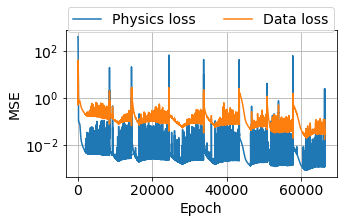

In [101]:
fig, ax = plt.subplots(figsize=(5,3))
#ax.semilogy(loss_neumann,label='Neumann')
#ax.semilogy(loss_dirichlet, label='Dirichlet')
#ax.semilogy(loss_pde, label='PDE')
ax.semilogy(torch.tensor(loss_dirichlet) + torch.tensor(loss_pde) + torch.tensor(loss_neumann), label='Physics loss')
ax.semilogy(loss_data, label='Data loss')
fig.legend(ncol=2, bbox_to_anchor=(0.97,1.07))
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.grid()
#ax.set_title('Losses for SSA training')
fig.tight_layout()
#fig.savefig('figs/SSA_loss.png', dpi=600)


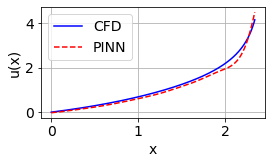

In [102]:
fig, ax = plt.subplots(figsize=(4,2.5))
ax.plot(xu_val, u_val, ls='solid', color='blue', label='CFD')
ax.plot(xu_val, net(x).detach(), ls='dashed', color='red', label='PINN')
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig('./figs/SSA_comparison.png', dpi=600)

# 